In [123]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Modify the image path

In [124]:
image_path = "./test_images/yellow-earrings.jpg"
image_user = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_user, cv2.COLOR_BGR2RGB)

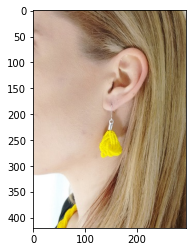

In [125]:
plt.imshow(image_rgb)

**Here's a brief overview of the selection process:**

1. Left-click and drag the mouse to define the rectangle. Release the left mouse button to finalize the rectangle selection.
2. Right-click on the image to select the additional point. The point will be recorded as the extra_point.
3. Press the "c" key to complete the selection process and continue with the code execution.

Press "r" to restart selection if you make a mistake

In [126]:
def select_rectangle_with_point(image):
    """
    Allows the user to select a rectangle and an additional point on the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        tuple: A tuple containing the following elements:
            - (tuple): The top left coordinates of the selected rectangle.
            - (tuple): The bottom right coordinates of the selected rectangle.
            - (tuple): The coordinates of the additional point.
    """

    # Make a copy of the image for display
    clone = image.copy()

    # Initialize variables for storing coordinates and selection status
    start_point = None
    end_point = None
    extra_point = None
    selection_completed = False

    def mouse_callback(event, x, y, flags, param):
        nonlocal start_point, end_point, extra_point, selection_completed

        if event == cv2.EVENT_LBUTTONDOWN:
            start_point = (x, y)

        elif event == cv2.EVENT_LBUTTONUP:
            end_point = (x, y)
            cv2.rectangle(clone, start_point, end_point, (0, 255, 0), 2)
            cv2.imshow("Image", clone)

        elif event == cv2.EVENT_RBUTTONDOWN:
            extra_point = (x, y)
            cv2.circle(clone, extra_point, 3, (0, 0, 255), -1)
            cv2.imshow("Image", clone)

    # Create a window and set the mouse callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", mouse_callback)

    # Start the selection loop
    while not selection_completed:
        cv2.imshow("Image", clone)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("r"):
            # Reset the selection if 'r' key is pressed
            clone = image.copy()
            start_point = None
            end_point = None
            extra_point = None

        elif key == ord("c"):
            # Complete the selection if 'c' key is pressed
            if start_point is not None and end_point is not None:
                selection_completed = True

    # Close the OpenCV windows
    cv2.destroyAllWindows()

    # If the rectangle or the extra point is not selected, return None
    if start_point is None or end_point is None or extra_point is None:
        return None

    # Collect coordinates of vertices
    top_left = (min(start_point[0], end_point[0]), min(start_point[1], end_point[1]))
    bottom_right = (max(start_point[0], end_point[0]), max(start_point[1], end_point[1]))
    
    # Return the selected coordinates
    return top_left, bottom_right, extra_point

Top Left:  (99, 159)
Bottom Right:  (198, 290)
Extra Point:  (154, 255)


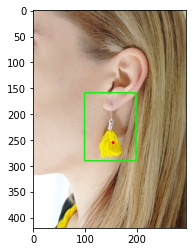

In [127]:
# Example 
image = image_user.copy()

selected_region = select_rectangle_with_point(image)
if selected_region is not None:
    top_left, bottom_right, extra_point = selected_region
    print("Top Left: ", top_left)
    print("Bottom Right: ", bottom_right)
    print("Extra Point: ", extra_point)

    # Draw the rectangle and extra point on the image and save it
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.circle(image, extra_point, 3, (0, 0, 255), -1)
    cv2.imwrite("selected_image.jpg", image)

    # Display the saved image using matplotlib
    selected_image = plt.imread("selected_image.jpg")
    plt.imshow(selected_image)
    #plt.axis('off')
    plt.show()

# Implement Segment Anything

This code is from the predictor_example.ipynb at https://github.com/facebookresearch/segment-anything/tree/main/notebooks

In [128]:
import numpy as np
import torch

In [129]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


### Selecting objects with SAM

In [130]:
image = image_user.copy()

In [131]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" # comment out if no GPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device) # comment out if no GPU

predictor = SamPredictor(sam)

In [132]:
predictor.set_image(image)

In [133]:
# creating xyxy variable so that it works with the predictor model SAM

xyxy = list(top_left)
temp = list(bottom_right)
xyxy[len(xyxy):] = temp
xyxy

[99, 159, 198, 290]

In [134]:
input_box = np.array(xyxy)
input_point = np.array(list([extra_point]))
input_label = np.array([1])

In [135]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

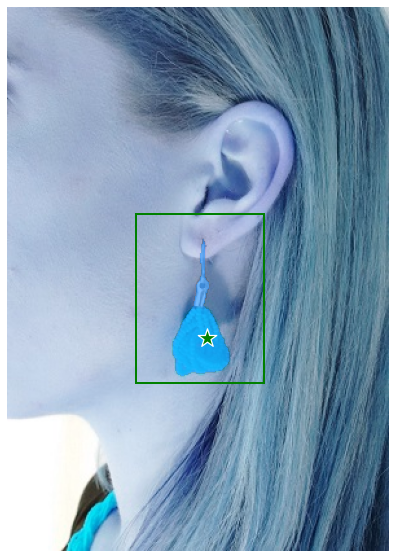

In [136]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [137]:
int_mask = masks.astype(int)

In [138]:
width = image_user.shape[0]
height = image_user.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==0:
            image_user[i][j]=(255,255,255)

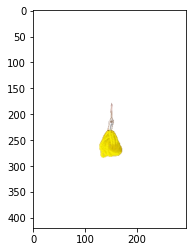

In [139]:
plt.imshow(cv2.cvtColor(image_user, cv2.COLOR_BGR2RGB))

In [140]:
cv2.imwrite("./test_images/yellow-earrings-cropped.jpg", image_user)

True